In [1]:
# Breaks File into Chunks

def chunk_text(text, chunk_size=1000):
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size):
        chunk = ' '.join(words[i:i+chunk_size])
        chunks.append(chunk)
    return chunks

# Read the book in smaller chunks to avoid segmentation fault
def read_file_in_chunks(file_path, chunk_size=1000):
    with open(file_path, "r", encoding="utf-8") as file:
        while True:
            chunk = file.read(chunk_size * 6)  # Read approximately 1000 words (assuming average word length of 6 characters)
            if not chunk:
                break
            yield chunk

# Process the file in chunks
file_path = "./cleaned_GOT.txt"
chunks = list(read_file_in_chunks(file_path))
len(chunks)

265

In [2]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# Loads spacy model since we were having issues

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('sentencizer')

In [4]:
# Copy pasted from instructions

def extract_relationships(doc):
    relationships = []
    for sent in doc.sents:
        root = sent.root
        subject = None
        obj = None
        for child in root.children:
            if child.dep_ == "nsubj":
                subject = child
            if child.dep_ in ["dobj", "pobj"]:
                obj = child
        if subject and obj:
            relationships.append((subject, root, obj))
    return relationships

def process_document(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    relationships = extract_relationships(doc)
    return entities, relationships

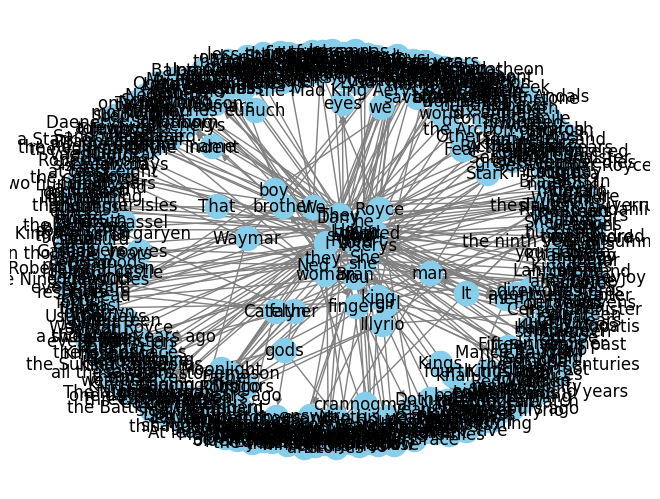

In [5]:
def build_knowledge_graph(documents):
    G = nx.DiGraph()
    for doc in documents:
        entities, relationships = process_document(doc)
        for entity, entity_type in entities:
            G.add_node(entity, type=entity_type)
        for subj, pred, obj in relationships:
            G.add_edge(subj.text, obj.text, relation=pred.text)
    return G

documents = chunks[0:15]  # The documents are the chunks of the book, 15 chunks to visualize a simple graph
knowledge_graph = build_knowledge_graph(documents)

# Visualize the graph or use it for further analysis
nx.draw(knowledge_graph, with_labels=True, node_color="skyblue", edge_color="gray")
plt.show()

In [6]:
documents = chunks  # All chunks of the book
knowledge_graph = build_knowledge_graph(documents)

In [13]:
from langchain import OpenAI, PromptTemplate, LLMChain
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
import os
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv()

# Get key from the env
openai_api_key = os.getenv('OPENAI_API_KEY')

# Initialize components
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)
vectorstore = FAISS.from_texts(documents, embeddings)
llm = OpenAI(temperature=0)

# RAG prompt template
rag_template = """Context: {context}

Question: {question}

Answer:"""
rag_prompt = PromptTemplate(template=rag_template, input_variables=["context", "question"])
rag_chain = LLMChain(llm=llm, prompt=rag_prompt)

def rag_query(question, k=3):
    relevant_docs = vectorstore.similarity_search(question, k=k)
    context = "\n".join([doc.page_content for doc in relevant_docs])
    return rag_chain.run(context=context, question=question)

In [12]:
def get_relevant_triples(question, graph, k=5):
    entities = nlp(question).ents
    relevant_triples = []
    for entity in entities:
        if entity.text in graph:
            neighbors = list(graph.neighbors(entity.text))
            for neighbor in neighbors[:k]:
                edge_data = graph.get_edge_data(entity.text, neighbor)
                relevant_triples.append(f"{entity.text} {edge_data['relation']} {neighbor}")
    return relevant_triples

def krag_query(question, k=3):
    relevant_docs = vectorstore.similarity_search(question, k=k)
    context = "\n".join([doc.page_content for doc in relevant_docs])
    relevant_triples = get_relevant_triples(question, knowledge_graph)
    triples_context = "\n".join(relevant_triples)
    
    krag_template = """Context: {context}

Relevant Knowledge Graph Triples:
{triples_context}

Question: {question}

Answer:"""
    krag_prompt = PromptTemplate(template=krag_template, input_variables=["context", "triples_context", "question"])
    krag_chain = LLMChain(llm=llm, prompt=krag_prompt)
    
    return krag_chain.run(context=context, triples_context=triples_context, question=question)